# Imports & variable definition

In [11]:
import csv
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [245]:
inFile=".../450k/relatedness/relatedness_data_450k_participants.tsv"
outFile=".../450k/relatedness/related_individuals.txt"
outFileFinal=".../450k/relatedness/related_individuals_with_interpretation.txt"
samplesToRemove=".../450k/relatedness/related_samples_to_remove"

**TO-do: explain how did we get input file!!!**

# Create couples

**Input** data contains the following fields:

> **22011** - field is used to identify pairs of participants who are estimated to be genetically related. More [here](https://biobank.ndph.ox.ac.uk/showcase/field.cgi?id=22011).

> **22012** -  field gives the kinship coefficient associated with each pair of participants. More [here](https://biobank.ndph.ox.ac.uk/showcase/field.cgi?id=22012).

> **22018** - field identifies the persons excluded from the calculations. More [here](https://biobank.ndph.ox.ac.uk/showcase/field.cgi?id=22018).

**Output**: 

Tab-separated file of format: `eid-1` `eid-2` `kinship-coefficient`

In [39]:
def create_couples(inFile, outFile):
    '''
    This function gets a phenotipic file that includes fields 22011,22012,22018 as an input file
    The output is a list of couples by identifiers <ID1,ID2,kinship>
    '''
    # define fields
    exclude=22018
    pairs=22011
    kinship=22012
    
    with open(inFile,"rt") as pheno_File, open (outFile,"w") as final:
        # parse csv files
        reader=csv.reader(pheno_File,delimiter="\t")
        writer=csv.writer(final,delimiter="\t")
        
        # read first row, save the indexes of the fields
        field_pairs=[]
        field_kinship=[]
        
        fields=next(reader)
        
        for i in fields:
            if str(exclude) in str(i):
                field_exclude=fields.index(i)
            #a list of all fields that are related to the phenotype (X-1.0, X-1.1, X-2.0...)
            elif str(pairs) in str(i):                                          
                field_pairs.append(fields.index(i))
            elif str(kinship) in str(i):
                field_kinship.append(fields.index(i))
        l_zipped = list(zip(field_pairs,field_kinship))    
        
        # iterate over the remaining rows and collect related pairs
        
        d_samples={}
        d_pairs={}
        
        for r in reader:
            d_samples[r[0]]=[]
            
            
            if r[field_exclude] != 1 and r[field_exclude] != 2:
                for c in field_pairs:
                    if r[c] != "":
                        if r[c] not in d_pairs.keys():
                            d_pairs[r[c]] = [r[0]]
                        else:
                            d_pairs[r[c]].append(r[0])
                   
                
            for s in l_zipped:
                if s[0]!="":
                    if r[s[0]]!="":
                        d_samples[r[0]].append([r[s[0]],r[s[1]]])
        
        for k,v in d_pairs.items():
            if len(v)==2:
                if len(d_samples[v[0]])>1:
                    for i in d_samples[v[0]]:
                        if i[0]==k:
                            nl=[str(v[0]),str(v[1]),i[1]]
                            
                else:
                    nl=[str(v[0]),str(v[1]),d_samples[v[0]][0][1]]
                writer.writerow(nl)

In [41]:
start = datetime.datetime.now()

create_couples(inFile, outFile)

print (f"Step finished, elapsed time: {datetime.datetime.now()-start}")

Step finished, elapsed time: 0:00:01.377009


In [115]:
!head -5 $outFile

1003692	3498490	0.218

1006054	2386508	0.108

1006881	2821126	0.059

1006881	3623498	0.242

1014860	1232780	0.238



In [116]:
!wc -l $outFile

9684 .../450k/relatedness/related_individuals.txt


# Interpreting kinship coefficient

**Input**:

File, generated at the previous step




**Output**: 

Tab-separated file of format: `eid-1` `eid-2` `kinship-coefficient` `kinship-interpretation`

In [105]:
def kinship_interpretation(inFile, outFile):
    '''
    This function gets the "create_couples" output as an input
    It adds a column with the infer relationship
    '''
    with open (inFile, "r") as inputf, open (outFile, "w") as final:
        reader= csv.reader (inputf, delimiter="\t")
        writer= csv.writer (final, delimiter="\t")

        for row in reader:
            nl= row[:]
            if float(row[2])>=0.354:
                nl.append("duplicate/MZ twin")
            elif float(row[2])>=0.177 and float(row[2])<0.354:
                    nl.append("1st-degree")
            elif float(row[2])>=0.0884 and float(row[2])<0.177:
                nl.append("2nd-degree")
            elif float(row[2])>=0.0442 and float(row[2])<0.0884:
                nl.append("3rd-degree")
            else:
                nl.append("no_inffered_relationship")
            writer.writerow(nl)

In [109]:
start = datetime.datetime.now()

kinship_interpretation(outFile, outFileFinal)

print (f"Step finished, elapsed time: {datetime.datetime.now()-start}")

Step finished, elapsed time: 0:00:00.054456


In [117]:
!head -5 $outFileFinal

1003692	3498490	0.218	1st-degree

1006054	2386508	0.108	2nd-degree

1006881	2821126	0.059	3rd-degree

1006881	3623498	0.242	1st-degree

1014860	1232780	0.238	1st-degree



In [118]:
!wc -l $outFileFinal

9684 .../450k/relatedness/related_individuals_with_interpretation.txt


# Remove related samples

**Input**:

File, generated at the previous step




**Output**: 

Tab-separated file with the samples to exclude, format: `eid` 

In [247]:
def samples_to_remove(inFile, outFileNoExt):
    '''
    this function gets the "kinship_interpretation" output as an input
    It creats a  list of related samples that needs to be excluded
    '''
    with open (inFile, "r") as inputf, open (outFileNoExt+".txt", "w") as final:
        reader= csv.reader (inputf, delimiter="\t")
        writer= csv.writer (final, delimiter="\t")

        pairs=[]

        for r in reader:
            # create a nested list of all couples 2nd degree or closer
            if r[3]!="3rd-degree" and r[3]!="no_inffered_relationship": 
                pairs.append([r[0],r[1]])
        
        
        # as long as there are pairs in the list, 
        # check which sample has the most relationships 
        # and delete the pairs that it's in
        while len(pairs)>0:                                                             
            d={}
            for p in pairs:
                if p[0] not in d:
                    d[p[0]]=1
                else:
                    d[p[0]]+=1
                    
                if p[1] not in d:
                    d[p[1]]=1
                else:
                    d[p[1]]+=1
                    
            most_related = max(d,key=d.get)
            writer.writerow([most_related])
            for p in pairs:
                if most_related in p:
                    pairs.remove(p)

    os.system ("cat " +outFileNoExt+ ".txt |sort|uniq > " +outFileNoExt +"_final.txt")
    os.system ("rm -f "+outFileNoExt+ ".txt")

In [248]:
start = datetime.datetime.now()

samples_to_remove(outFileFinal, samplesToRemove)

print (f"Step finished, elapsed time: {datetime.datetime.now()-start}")

Step finished, elapsed time: 0:00:03.584348


In [119]:
!head -5 $samplesToRemove'_final.txt'

1001548

1002035

1002177

1002758

1003692



In [120]:
!wc -l $samplesToRemove'_final.txt'

3664 .../450k/relatedness/related_samples_to_remove_final.txt


**Note**: when running this algorithm second time, it may produce a bit different result since there are samples with the same relatedness count. We delete a random(?) one. 

# New relatedness coefficitent

In [40]:
import pandas as pd

def plot_kinship_dist(relatedness_data):
    f, ax = plt.subplots(1, 1, figsize=(5, 3))
    relatedness_data['Kinship'][relatedness_data['Kinship'] >= 0].hist(bins=100)

    ax.vlines(0.354, 0, 12000, color='r', label='MZ twin/duplicate')
    ax.text(0.354 + 0.005, 12000, 'MZ twin/duplicate', rotation=90, verticalalignment='top')

    ax.vlines(0.177, 0, 12000, color='r', label='1st-degree')
    ax.text(0.177 + 0.005, 12000, '1st-degree', rotation=90, verticalalignment='top')

    ax.vlines(0.0884, 0, 12000, color='r', label='2nd-degree')
    ax.text(0.0884 + 0.005, 12000, '2nd-degree', rotation=90, verticalalignment='top')

    ax.vlines(0.0442, 0, 12000, color='r', label='3rd-degree')
    ax.text(0.0442 + 0.005, 12000, '3rd-degree', rotation=90, verticalalignment='top')

    plt.show()


In [36]:
with open (".../450k/samples/relatedness/related_samples_to_remove_final.txt", "r") as f:
    samples_to_remove = f.read().splitlines()

print (f"Number OLD of samples to remove: {len(samples_to_remove)}")
print (f"Samples to remove: {samples_to_remove[:3]}")

Number OLD of samples to remove: 3664
Samples to remove: ['1001548', '1002035', '1002177']


In [38]:
relatedness_data = pd.read_csv(".../relatedness.txt", sep=' ')

# select parent-offsprings and siblings

lower_bound = 1/(2**3.5)
print ("Lower bound:", lower_bound)
print()

related_pairs = relatedness_data[(relatedness_data['Kinship'] > lower_bound)][['ID1', 'ID2']]
print ("Related pairs:", len(related_pairs))

related_pairs = related_pairs[~(related_pairs['ID1'].astype(str).isin(samples_to_remove) | related_pairs['ID2'].astype(str).isin(samples_to_remove))]

print ("Related pairs without deleted:", len(related_pairs))


Lower bound: 0.08838834764831843

Related pairs: 40166
Related pairs without deleted: 35526


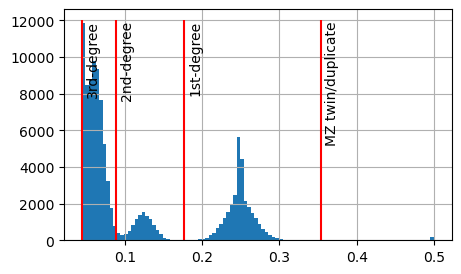

In [41]:
plot_kinship_dist(relatedness_data)

In [23]:
full_related_pairs = pd.concat([related_pairs[['ID1', 'ID2']], related_pairs.rename(columns={'ID1':'ID2', 'ID2':'ID1'})[['ID1', 'ID2']]]).drop_duplicates()

print ("Full related pairs:", len(full_related_pairs))

deleted_samples =[]
counter = 0

while full_related_pairs.shape[0] > 0:
    counts = full_related_pairs.groupby('ID1').size().sort_values(ascending=False)
    most_related = counts.index[0]

    deleted_samples.append(most_related)

    full_related_pairs = full_related_pairs[~(full_related_pairs['ID1'] == most_related) & ~(full_related_pairs['ID2'] == most_related)]

    counter += 1
    if counter % 10000 == 0:
        print()
        print (f"Deleted {counter} samples")
        print (f"Related pairs left: {full_related_pairs.shape[0]}")


Full related pairs: 71052

Deleted 10000 samples
Related pairs left: 42460

Deleted 20000 samples
Related pairs left: 22460

Deleted 30000 samples
Related pairs left: 2460


In [25]:
print ("Deleted in nature paper:", 409617 - 342717)
print ("Deleted in this script:", len(deleted_samples))
print ("Deleted in total:", len(deleted_samples) + len(samples_to_remove))

Deleted in nature paper: 66900
Deleted in this script: 31230
Deleted in total: 34894


In [34]:
related_pairs[~(related_pairs['ID1'].isin(deleted_samples) | related_pairs['ID2'].isin(deleted_samples))]

Empty DataFrame
Columns: [ID1, ID2]
Index: []

In [100]:
with open (".../450k/samples/relatedness/related_samples_to_remove_final_450k.txt", "w") as f:
    for s in samples_to_remove:
        f.write(str(s) + "\n")
        
    for s in deleted_samples:
        f.write(str(s) + "\n")

In [102]:
!wc -l .../450k/samples/relatedness/related_samples_to_remove_final_450k.txt

34894 .../450k/samples/relatedness/related_samples_to_remove_final_450k.txt


In [52]:
with open(".../450k/samples/european_non_related_no_withdrawal_to_include.txt", 'r') as f:
    european_non_rel_samples = [l.strip() for l in f.readlines()]

In [58]:
deleted_samples = [str(x) for x in deleted_samples]

print ('Deleted samples:', len(deleted_samples))
print ('European non related samples:', len(european_non_rel_samples))
print ('Intersection:', len(set(deleted_samples) & set(european_non_rel_samples)))

print ('Deletion:', len(set(european_non_rel_samples) - set(deleted_samples)))

Deleted samples: 31230
European non related samples: 406194
Intersection: 27443
Deletion: 378751


In [86]:
deleted_samples_set = set(deleted_samples)

with open (".../450k/samples/european_non_related_no_withdrawal_to_include_450k.txt", "w") as f:
    for sample in european_non_rel_samples:
        if sample not in deleted_samples_set:
            f.write(str(sample) + "\n")

In [87]:
!wc -l .../450k/samples/european_non_related_no_withdrawal_to_include_450k.txt

378751 .../450k/samples/european_non_related_no_withdrawal_to_include_450k.txt


In [88]:
!wc -l .../450k/samples/european_non_related_no_withdrawal_to_include.txt

406194 .../450k/samples/european_non_related_no_withdrawal_to_include.txt


# Final check

In [28]:
with open(".../450k/samples/european_non_related_no_withdrawal_to_include_450k.txt", 'r') as f:
    european_non_rel_samples_new = [l.strip() for l in f.readlines()]

european_non_rel_samples_new = set(european_non_rel_samples_new)

print ('Number of samples:', len(european_non_rel_samples_new))

Number of samples: 378751


In [31]:
with open(".../450k/samples/european_non_related_no_withdrawal_to_include.txt", 'r') as f:
    european_non_rel_samples = [l.strip() for l in f.readlines()]

european_non_rel_samples = set(european_non_rel_samples)
print ('Number of samples, old:', len(european_non_rel_samples))

Number of samples, old: 406194


In [32]:
(related_pairs['ID1'].astype(str).isin(european_non_rel_samples_new) & related_pairs['ID2'].astype(str).isin(european_non_rel_samples_new)).sum()

0

In [33]:
(related_pairs['ID1'].astype(str).isin(european_non_rel_samples_new) | related_pairs['ID2'].astype(str).isin(european_non_rel_samples_new)).sum()

29115

In [35]:
(related_pairs['ID1'].astype(str).isin(european_non_rel_samples) & related_pairs['ID2'].astype(str).isin(european_non_rel_samples)).sum()

30087